In this noteboook, I read in the Kaggle dataset.  Our goal is to have regressions to create scores for our players at each of the following features:

* Ace percentage (server and returner)
* 1st serve percentage (server and returner(?))
    * Not clear that returner's quality affects the pct of 1st serves in
* 1st serve point quality (server and returner)
* 2nd serve percentage (server and returner(?))
    * Not clear that returner's quality affects pct of 1st serves in
* 2nd serve point quality (server and returner)


#### TODO:
* Make this logistic regression instead of linear regression
* Tune weight
* Tune surface weights

In [1]:
from fetch.kaggle import parse_atp_data

df = parse_atp_data()

/Users/siddhantjagadish/Documents/DataProjects/tennis_modeling/tennis_modeling/lib/python2.7/site-packages/IPython/core/interactiveshell.py:2818: DtypeWarning: Columns (9,19) have mixed types. Specify dtype option on import or set low_memory=False.
  if self.run_code(code, result):


In [4]:
MIN_TEST_DATE = '2015-01-01'
MAX_TEST_DATE = '2017-01-01'

train_df = df[
    (df['tourney_date'] < MIN_TEST_DATE) &
    (df['surface'] == 'Hard')  # TODO: Surface weights
].copy()
test_df = df[
    (df['tourney_date'] > MIN_TEST_DATE) &
    (df['tourney_date'] < MAX_TEST_DATE) &
    (df['surface'] == 'Hard')  # TODO: Surface Weights
].copy()

In [5]:
import pandas as pd

# Get player map
part1 = df[['winner_id', 'winner_name']].drop_duplicates('winner_id')
part2 = df[['loser_id', 'loser_name']].drop_duplicates('loser_id')
part1.rename(columns={'winner_id': 'player_id', 'winner_name': 'player_name'}, inplace=True)
part2.rename(columns={'loser_id': 'player_id', 'loser_name': 'player_name'}, inplace=True)
player_map_df = pd.concat([part1, part2])
player_map_df.drop_duplicates('player_id', inplace=True)

In [6]:
def sipko_weights(cur_date, train_df, disc, date_col='date', flat_time=1.):
    # Needs to be sorted prior to using
    # These are the time decay weights used in the paper.
    # min(disc ^ (# years elapsed), disc ^ (flat_time))
    max_weight = disc ** flat_time
    days_ago = (pd.to_datetime(cur_date) - train_df[date_col]).map(lambda x: x.days)
    years_ago = days_ago / 365.
    weights = disc ** years_ago
    return weights.clip(upper=max_weight)


_s_weights = sipko_weights(
    train_df['tourney_date'].max(),
    train_df,
    0.8,
    date_col='tourney_date',
    flat_time=1.
)

In [8]:
def characterize_solution(coef, inverse_player_mapping):
    coef_df = pd.DataFrame(
        list(enumerate(coef)),
        columns=['_mapped_id', 'coef']
    )
    coef_df['player_id'] = coef_df['_mapped_id'].map(lambda x: inverse_player_mapping[x])
    coef_df['side'] = coef_df['player_id'].map(lambda x: 'server' if x > 0 else 'returner')
    coef_df['player_id'] = coef_df['player_id'].abs()
    coef_df = pd.merge(
        coef_df,
        player_map_df,
        on='player_id'
    )
    return coef_df

In [9]:
from fetch.regression_features import get_X_y
from sklearn.linear_model import Ridge 
from fetch.regression_features import get_player_mapping

def do_model_for_feat(feat, train_df, alpha=100.):
    pm_df = df[
        df['p1_%s' % feat].notnull() &
        df['p2_%s' % feat].notnull()
    ]
    pm, ipm = get_player_mapping(pm_df)

    train_X, train_y, pm, ipm, weights = get_X_y(
        train_df,
        feat,
        player_mapping=pm,
        inv_player_mapping=ipm,
        weights=_s_weights
    )
    lin = Ridge(fit_intercept=True, alpha=alpha)
    lin.fit(train_X, train_y, sample_weight=weights)
    out = characterize_solution(lin.coef_, ipm)
    print lin.intercept_
    print out[out['side'] == 'server'].sort_values(by='coef', ascending=False).head(10)
    print out[out['side'] == 'returner'].sort_values(by='coef', ascending=True).head(10)
    return out

first_won = do_model_for_feat('1stWon_pct', train_df)

0.720942623584
      _mapped_id      coef  player_id    side         player_name
483         3794  0.061416     105683  server        Milos Raonic
2595        2646  0.057955     103333  server        Ivo Karlovic
3962        2975  0.055793     103819  server       Roger Federer
1275        3365  0.047243     104607  server       Tomas Berdych
1323        3339  0.042999     104542  server  Jo Wilfried Tsonga
957         3536  0.042077     105023  server         Sam Querrey
4010        3115  0.041824     104053  server        Andy Roddick
1321        3340  0.040109     104545  server          John Isner
1029        3494  0.029969     104925  server      Novak Djokovic
801         3623  0.029740     105227  server         Marin Cilic
      _mapped_id      coef  player_id      side         player_name
1028         524 -0.054726     104925  returner      Novak Djokovic
1032         526 -0.047072     104918  returner         Andy Murray
3963        3955 -0.040881     103819  returner       R

In [13]:
second_won = do_model_for_feat('2ndWon_pct', train_df)

0.565565603539
      _mapped_id      coef  player_id    side            player_name
3962        2975  0.047598     103819  server          Roger Federer
1029        3494  0.047451     104925  server         Novak Djokovic
1163        3428  0.044111     104745  server           Rafael Nadal
1321        3340  0.031482     104545  server             John Isner
4010        3115  0.029732     104053  server           Andy Roddick
483         3794  0.028661     105683  server           Milos Raonic
1521        3231  0.027429     104269  server      Fernando Verdasco
1159        3430  0.025462     104755  server        Richard Gasquet
805         3621  0.024456     105223  server  Juan Martin Del Potro
1815        3065  0.023627     103970  server           David Ferrer
      _mapped_id      coef  player_id      side            player_name
1028         524 -0.066950     104925  returner         Novak Djokovic
1032         526 -0.057035     104918  returner            Andy Murray
1814         

#### Investigate some of these features... 

In [14]:
MIN_TEST_DATE = '2015-01-01'
MAX_TEST_DATE = '2017-01-01'

train_df = df[
    (df['tourney_date'] < MIN_TEST_DATE) &
    (df['surface'] == 'Hard')  # TODO: Surface weights
].copy()
test_df = df[
    (df['tourney_date'] > MIN_TEST_DATE) &
    (df['tourney_date'] < MAX_TEST_DATE) &
    (df['surface'] == 'Hard')  # TODO: Surface Weights
].copy()

In [15]:
rel_players = test_df.sort_values(
    by='tourney_date', ascending=True
).drop_duplicates('winner_id', keep='last')
rel_players = rel_players[
    (rel_players['winner_rank'] < 30) &
    (rel_players['tourney_date'] > '2015-01-01')
]
rel_players = sorted(rel_players['winner_name'].unique())
rel_players

['Albert Ramos',
 'Alexander Zverev',
 'Andy Murray',
 'Bernard Tomic',
 'David Ferrer',
 'David Goffin',
 'Dominic Thiem',
 'Gael Monfils',
 'Gilles Simon',
 'Grigor Dimitrov',
 'Ivo Karlovic',
 'Jack Sock',
 'Jo Wilfried Tsonga',
 'John Isner',
 'Kei Nishikori',
 'Lucas Pouille',
 'Marin Cilic',
 'Milos Raonic',
 'Nick Kyrgios',
 'Novak Djokovic',
 'Pablo Cuevas',
 'Rafael Nadal',
 'Richard Gasquet',
 'Roberto Bautista Agut',
 'Roger Federer',
 'Stanislas Wawrinka',
 'Tomas Berdych',
 'Viktor Troicki']

In [18]:
%matplotlib inline
from matplotlib import pyplot as plt

def compare_two(f1, f2, side='server'):
    f1_df = do_model_for_feat(f1, train_df)
    f2_df = do_model_for_feat(f2, train_df)
    f1_df.rename(columns={'coef': '%s_coef' % f1}, inplace=True)
    together = pd.merge(
        f1_df,
        f2_df[['player_id', 'side', 'coef']],
        on=['player_id', 'side']
    )
    together.rename(columns={'coef': '%s_coef' % f2}, inplace=True)

    rel = together[together['side'] == side]
    plot_rel = rel[rel['player_name'].isin(rel_players)]
    fig, ax = plt.subplots()
    ax.scatter(plot_rel['%s_coef' % f1], plot_rel['%s_coef' % f2])
    for i, txt in enumerate(plot_rel['player_name'].tolist()):
        ax.annotate(
            txt,
            (plot_rel['%s_coef' % f1].iloc[i], plot_rel['%s_coef' % f2].iloc[i])
        )
    ax.set_xlabel('Normalized %s' % f1)
    ax.set_ylabel('Normalized %s' % f2)

0.596796119179
      _mapped_id      coef  player_id    side        player_name
1321        3340  0.047983     104545  server         John Isner
1163        3428  0.044692     104745  server       Rafael Nadal
3954        2956  0.039574     103786  server  Nikolay Davydenko
170           85  0.034358     103813  server    Jarkko Nieminen
1029        3494  0.034034     104925  server     Novak Djokovic
4010        3115  0.033856     104053  server       Andy Roddick
1967        2972  0.033239     103812  server     Victor Hanescu
1631        3171  0.032806     104166  server  Alex Bogomolov Jr
1521        3231  0.032297     104269  server  Fernando Verdasco
2595        2646  0.032286     103333  server       Ivo Karlovic
      _mapped_id      coef  player_id      side        player_name
156           78 -0.012913     103720  returner     Lleyton Hewitt
658          333 -0.012377     105453  returner      Kei Nishikori
1358         693 -0.009500     104500  returner   Somdev Devvarman
12

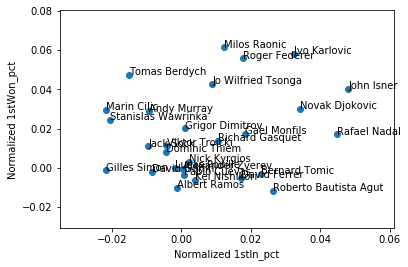

In [19]:
compare_two('1stIn_pct', '1stWon_pct')

0.596795876942
      _mapped_id      coef  player_id    side        player_name
1321        3340  0.047985     104545  server         John Isner
1163        3428  0.044691     104745  server       Rafael Nadal
3954        2956  0.039574     103786  server  Nikolay Davydenko
170           85  0.034357     103813  server    Jarkko Nieminen
1029        3494  0.034036     104925  server     Novak Djokovic
4010        3115  0.033856     104053  server       Andy Roddick
1967        2972  0.033238     103812  server     Victor Hanescu
1631        3171  0.032806     104166  server  Alex Bogomolov Jr
1521        3231  0.032295     104269  server  Fernando Verdasco
2595        2646  0.032286     103333  server       Ivo Karlovic
      _mapped_id      coef  player_id      side        player_name
156           78 -0.012913     103720  returner     Lleyton Hewitt
658          333 -0.012379     105453  returner      Kei Nishikori
1358         693 -0.009499     104500  returner   Somdev Devvarman
12

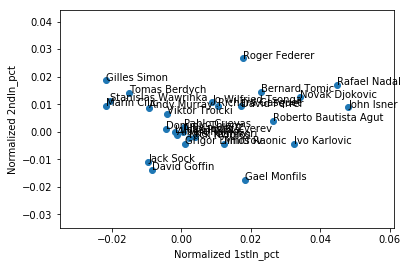

In [20]:
compare_two('1stIn_pct', '2ndIn_pct')

0.720950600039
      _mapped_id      coef  player_id    side         player_name
483         3794  0.061410     105683  server        Milos Raonic
2595        2646  0.057953     103333  server        Ivo Karlovic
3962        2975  0.055795     103819  server       Roger Federer
1275        3365  0.047242     104607  server       Tomas Berdych
1323        3339  0.042999     104542  server  Jo Wilfried Tsonga
957         3536  0.042079     105023  server         Sam Querrey
4010        3115  0.041827     104053  server        Andy Roddick
1321        3340  0.040108     104545  server          John Isner
1029        3494  0.029974     104925  server      Novak Djokovic
801         3623  0.029741     105227  server         Marin Cilic
      _mapped_id      coef  player_id      side         player_name
1028         524 -0.054722     104925  returner      Novak Djokovic
1032         526 -0.047069     104918  returner         Andy Murray
3963        3955 -0.040879     103819  returner       R

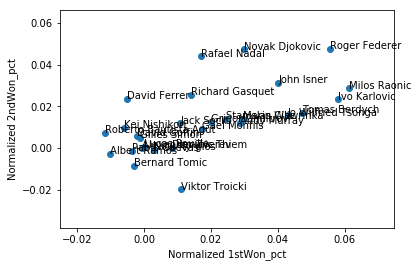

In [21]:
compare_two('1stWon_pct', '2ndWon_pct')

0.720949466412
      _mapped_id      coef  player_id    side         player_name
483         3794  0.061411     105683  server        Milos Raonic
2595        2646  0.057952     103333  server        Ivo Karlovic
3962        2975  0.055790     103819  server       Roger Federer
1275        3365  0.047242     104607  server       Tomas Berdych
1323        3339  0.042999     104542  server  Jo Wilfried Tsonga
957         3536  0.042079     105023  server         Sam Querrey
4010        3115  0.041828     104053  server        Andy Roddick
1321        3340  0.040109     104545  server          John Isner
1029        3494  0.029975     104925  server      Novak Djokovic
801         3623  0.029739     105227  server         Marin Cilic
      _mapped_id      coef  player_id      side         player_name
1028         524 -0.054731     104925  returner      Novak Djokovic
1032         526 -0.047073     104918  returner         Andy Murray
3963        3955 -0.040878     103819  returner       R

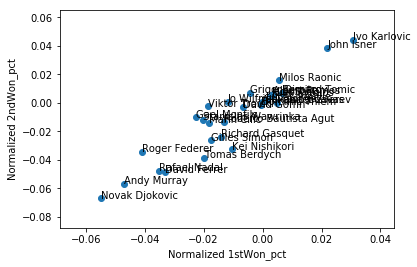

In [22]:
# Should expect these to be very highly correlated
compare_two('1stWon_pct', '2ndWon_pct', side='returner')

#### Backfill over time
Let's backfill these features over time...

In [36]:
MIN_TRAIN_DATE = '1990-01-01'
MIN_TEST_DATE = '2000-01-01'
MAX_TEST_DATE = '2017-01-01'

train_df = df[
    (df['tourney_date'] < MIN_TEST_DATE) &
    (df['surface'] == 'Hard')  # TODO: Surface weights
].copy()
test_df = df[
    (df['tourney_date'] > MIN_TEST_DATE) &
    (df['tourney_date'] < MAX_TEST_DATE) &
    (df['surface'] == 'Hard')  # TODO: Surface Weights
].copy()

In [39]:
import itertools
from fetch.regression_features import get_X_y
from sklearn.linear_model import Ridge 
from fetch.regression_features import get_player_mapping

FEATS = [
    'svWon_pct',
    '1stIn_pct',
    '1stWon_pct',
    '2ndIn_pct',
    '2ndWon_pct',
    'ace_pct'
]


def update_for_feat(feat, train_df, test_df):
    # TODO: Add test_df here too...
    pm_df = df[
        df['p1_%s' % feat].notnull() &
        df['p2_%s' % feat].notnull()
    ]
    pm, ipm = get_player_mapping(pm_df)
    _s_weights = sipko_weights(
        train_df['tourney_date'].max(),
        train_df,
        0.8,
        date_col='tourney_date',
        flat_time=1.
    )
    train_X, train_y, pm, ipm, weights = get_X_y(
        train_df,
        feat,
        player_mapping=pm,
        inv_player_mapping=ipm,
        weights=_s_weights
    )
    lin = Ridge(fit_intercept=True, alpha=100.)
    lin.fit(train_X, train_y, sample_weight=weights)

    coef_df = pd.DataFrame(
        [(ipm[k], v) for k, v in list(enumerate(lin.coef_))],
        columns=['player_id', '%s_coef' % feat]
    )    

    test_df = pd.merge(
        test_df,
        coef_df,
        left_on='p1_id',
        right_on='player_id'
    )
    test_df.rename(
        columns={'%s_coef' % feat: 'p1_%s_server' % feat},
        inplace=True
    )
    test_df.drop('player_id', axis=1, inplace=True)
    test_df = pd.merge(
        test_df,
        coef_df,
        left_on='p2_id',
        right_on='player_id'
    )
    test_df.rename(
        columns={'%s_coef' % feat: 'p2_%s_server' % feat},
        inplace=True
    )
    test_df.drop('player_id', axis=1, inplace=True)

    coef_df['player_id'] = -coef_df['player_id']
    test_df = pd.merge(
        test_df,
        coef_df,
        left_on='p1_id',
        right_on='player_id'
    )
    test_df.rename(
        columns={'%s_coef' % feat: 'p1_%s_returner' % feat},
        inplace=True
    )
    test_df.drop('player_id', axis=1, inplace=True)

    test_df = pd.merge(
        test_df,
        coef_df,
        left_on='p2_id',
        right_on='player_id'
    )
    test_df.rename(
        columns={'%s_coef' % feat: 'p2_%s_returner' % feat},
        inplace=True
    )
    test_df.drop('player_id', axis=1, inplace=True)
    return test_df 
    
    
def backfill(update_period=50):
    # Should backfill features
    out = []
    cur_date = test_df['tourney_date'].min()
    while(cur_date < pd.to_datetime(MAX_TEST_DATE)):
        print cur_date
        cur_train_df = df[
            (df['tourney_date'] >= MIN_TRAIN_DATE) &
            (df['tourney_date'] < cur_date)
        ].copy()
        cur_test_df = df[
            (df['tourney_date'] >= cur_date) &
            (df['tourney_date'] < cur_date + pd.Timedelta(days=update_period)) &
            (df['tourney_date'] < MAX_TEST_DATE) &
            (df['surface'] == 'Hard')
        ].copy()
        if cur_test_df.shape[0] > 0:
            for feat in FEATS:
                cur_test_df = update_for_feat(feat, cur_train_df, cur_test_df)
            out_feats = list(itertools.chain(*[[
                'p1_%s_server' % feat,
                'p1_%s_returner' % feat,
                'p2_%s_server' % feat,
                'p2_%s_returner' % feat
            ] for feat in FEATS]))
            out.append(cur_test_df[
                out_feats + ['tourney_date', 'match_id', 'y', 'surface']
            ])
        cur_date = cur_date + pd.Timedelta(days=update_period)
    return pd.concat(out)

In [40]:
backfilled_feats = backfill()

2000-01-03 00:00:00
2000-02-22 00:00:00
2000-04-12 00:00:00
2000-06-01 00:00:00
2000-07-21 00:00:00
2000-09-09 00:00:00
2000-10-29 00:00:00
2000-12-18 00:00:00
2001-02-06 00:00:00
2001-03-28 00:00:00
2001-05-17 00:00:00
2001-07-06 00:00:00
2001-08-25 00:00:00
2001-10-14 00:00:00
2001-12-03 00:00:00
2002-01-22 00:00:00
2002-03-13 00:00:00
2002-05-02 00:00:00
2002-06-21 00:00:00
2002-08-10 00:00:00
2002-09-29 00:00:00
2002-11-18 00:00:00
2003-01-07 00:00:00
2003-02-26 00:00:00
2003-04-17 00:00:00
2003-06-06 00:00:00
2003-07-26 00:00:00
2003-09-14 00:00:00
2003-11-03 00:00:00
2003-12-23 00:00:00
2004-02-11 00:00:00
2004-04-01 00:00:00
2004-05-21 00:00:00
2004-07-10 00:00:00
2004-08-29 00:00:00
2004-10-18 00:00:00
2004-12-07 00:00:00
2005-01-26 00:00:00
2005-03-17 00:00:00
2005-05-06 00:00:00
2005-06-25 00:00:00
2005-08-14 00:00:00
2005-10-03 00:00:00
2005-11-22 00:00:00
2006-01-11 00:00:00
2006-03-02 00:00:00
2006-04-21 00:00:00
2006-06-10 00:00:00
2006-07-30 00:00:00
2006-09-18 00:00:00


##### Train model on backfilled features 

In [88]:
MIN_TRAIN_DATE = '1990-01-01'
MIN_TEST_DATE = '2015-01-01'
MAX_TEST_DATE = '2017-01-01'

train_df = backfilled_feats[
    (backfilled_feats['tourney_date'] < MIN_TEST_DATE) &
    (backfilled_feats['surface'] == 'Hard')  # TODO: Surface weights
].copy()
test_df = backfilled_feats[
    (backfilled_feats['tourney_date'] > MIN_TEST_DATE) &
    (backfilled_feats['tourney_date'] < MAX_TEST_DATE) &
    (backfilled_feats['surface'] == 'Hard')  # TODO: Surface Weights
].copy()

In [89]:
TRAIN_FEATS = list(itertools.chain(*[[
    'p1_%s_server' % feat,
    'p1_%s_returner' % feat,
    'p2_%s_server' % feat,
    'p2_%s_returner' % feat
] for feat in FEATS]))
TRAIN_FEATS

['p1_svWon_pct_server',
 'p1_svWon_pct_returner',
 'p2_svWon_pct_server',
 'p2_svWon_pct_returner',
 'p1_1stIn_pct_server',
 'p1_1stIn_pct_returner',
 'p2_1stIn_pct_server',
 'p2_1stIn_pct_returner',
 'p1_1stWon_pct_server',
 'p1_1stWon_pct_returner',
 'p2_1stWon_pct_server',
 'p2_1stWon_pct_returner',
 'p1_2ndIn_pct_server',
 'p1_2ndIn_pct_returner',
 'p2_2ndIn_pct_server',
 'p2_2ndIn_pct_returner',
 'p1_2ndWon_pct_server',
 'p1_2ndWon_pct_returner',
 'p2_2ndWon_pct_server',
 'p2_2ndWon_pct_returner',
 'p1_ace_pct_server',
 'p1_ace_pct_returner',
 'p2_ace_pct_server',
 'p2_ace_pct_returner']

In [145]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score

rf = RandomForestClassifier(n_estimators=500, min_samples_leaf=10)
rf.fit(train_df[TRAIN_FEATS], train_df['y'])
preds = rf.predict_proba(test_df[TRAIN_FEATS])[:, 1]
roc_auc_score(test_df['y'], preds)

0.74371610409947364

In [144]:
from sklearn.ensemble import GradientBoostingClassifier

gbm = GradientBoostingClassifier(n_estimators=100, min_samples_leaf=10)
gbm.fit(train_df[TRAIN_FEATS], train_df['y'])
preds = gbm.predict_proba(test_df[TRAIN_FEATS])[:, 1]
roc_auc_score(test_df['y'], preds)

0.73746327569982695

In [91]:
imp_df = pd.DataFrame(
    zip(TRAIN_FEATS, rf.feature_importances_),
    columns=['feature', 'imp']
)

In [92]:
imp_df.sort_values(by='imp', ascending=False)

,feature,imp
2,p2_svWon_pct_server,0.072964
0,p1_svWon_pct_server,0.062612
16,p1_2ndWon_pct_server,0.058292
10,p2_1stWon_pct_server,0.058111
18,p2_2ndWon_pct_server,0.056035
3,p2_svWon_pct_returner,0.052334
11,p2_1stWon_pct_returner,0.049364
8,p1_1stWon_pct_server,0.045223
9,p1_1stWon_pct_returner,0.044620
19,p2_2ndWon_pct_returner,0.044351


##### More feature engineering to make symmetric

Above, our features are not being used in a symmetric way...in other words, the prediction depends on who is p1 and who is p2!

In [106]:
engineered_df = backfilled_feats.copy()

In [125]:
p1_feats = [x for x in TRAIN_FEATS if 'p1' in x]
new_feats = []
# First, straight up advantages
for feat in p1_feats:
    p2_feat = feat.replace('p1', 'p2')
    new_feat_name = feat.replace('_server', '_serve_diff')
    new_feat_name = new_feat_name.replace('_returner', '_return_diff')
    new_feat_name = new_feat_name.replace('p1_', '')
    engineered_df[new_feat_name] = engineered_df[feat] - engineered_df[p2_feat]
    new_feats.append(new_feat_name)
    
p1_serve_feats = [feat for feat in p1_feats if '_server' in feat]
for p1_serve in p1_serve_feats:
    p1_return = p1_serve.replace('_server', '_returner')
    p2_serve = p1_serve.replace('p1', 'p2')
    p2_return = p2_serve.replace('_server', '_returner')
    
    new_feat_name = p1_serve.replace('p1_', '').replace('_server', '_serve_advantage')
    engineered_df[new_feat_name] = (
        (engineered_df[p1_serve] + engineered_df[p2_return]) -
        (engineered_df[p2_serve] + engineered_df[p1_return])
    )
    new_feats.append(new_feat_name)

In [126]:
engineered_df[[
    '1stIn_pct_serve_diff',
    '1stIn_pct_return_diff',
    '1stIn_pct_serve_advantage'
]].head()

,1stIn_pct_serve_diff,1stIn_pct_return_diff,1stIn_pct_serve_advantage
0,-0.010885,-0.007373,-0.003512
1,0.030948,0.004645,0.026303
2,-0.015453,-0.010319,-0.005133
3,-0.017710,0.006984,-0.024694
4,-0.026413,-0.003354,-0.023059


In [127]:
MIN_TRAIN_DATE = '1990-01-01'
MIN_TEST_DATE = '2015-01-01'
MAX_TEST_DATE = '2017-01-01'

train_df = engineered_df[
    (engineered_df['tourney_date'] < MIN_TEST_DATE) &
    (engineered_df['surface'] == 'Hard')  # TODO: Surface weights
].copy()
test_df = engineered_df[
    (engineered_df['tourney_date'] > MIN_TEST_DATE) &
    (engineered_df['tourney_date'] < MAX_TEST_DATE) &
    (engineered_df['surface'] == 'Hard')  # TODO: Surface Weights
].copy()

In [133]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score

rf = RandomForestClassifier(n_estimators=500, min_samples_leaf=10, max_features=10)
rf.fit(train_df[new_feats], train_df['y'])
preds = rf.predict_proba(test_df[new_feats])[:, 1]
roc_auc_score(test_df['y'], preds)

0.71723869178884159

In [138]:
from sklearn.ensemble import GradientBoostingClassifier

gbm = GradientBoostingClassifier()
gbm.fit(train_df[new_feats], train_df['y'])
preds = gbm.predict_proba(test_df[new_feats])[:, 1]
roc_auc_score(test_df['y'], preds)

0.72018435778267842

In [134]:
imp_df = pd.DataFrame(
    zip(new_feats, rf.feature_importances_),
    columns=['feature', 'imp']
)
imp_df.sort('imp', ascending=False)

/Users/siddhantjagadish/Documents/DataProjects/tennis_modeling/tennis_modeling/lib/python2.7/site-packages/ipykernel_launcher.py:5: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)
  """


,feature,imp
12,svWon_pct_serve_advantage,0.214941
14,1stWon_pct_serve_advantage,0.109349
8,2ndWon_pct_serve_diff,0.056328
0,svWon_pct_serve_diff,0.053848
16,2ndWon_pct_serve_advantage,0.049461
7,2ndIn_pct_return_diff,0.047957
3,1stIn_pct_return_diff,0.046597
11,ace_pct_return_diff,0.043549
6,2ndIn_pct_serve_diff,0.040459
15,2ndIn_pct_serve_advantage,0.040246


In [137]:
preds.mean()

0.50025979674157695

#### Make symmetric by including each data point twice? 

TODO:
    * Add feature for winning the match...likely very important
    * Backfill more frequently (requires sorting by tourney date and round / match_num)
    * Make features subtractions of each other
        * Straight differences don't seem to work too well...
        * Include each match twice, one each way...this way has to be symmetric
        * Include all symmetric differences and regularize model like cray?
    * Add features about clutchness / break points?
    * Tune RF, recency weights, etc.
    * See if same regularization over time makes signals larger over time...
    * Include head to head where it exists...
    * ANN vs. RF?